In [1]:
import re
from simhash import Simhash as simhash

import pandas as pd
import numpy as np

# Import Data from CSV

In [2]:
columns = ['ID', 'Has Duplicate', 'dup_of', 'Title', 'Author', 
                 'Format', 'Language', 'Published/Created', 
                 'Date', 'Description', 'Edition']

In [3]:
features = ['ID', 'title', 'author', 'format', 'language', 'published', 'date', 'description', 'has_duplicate', 'edition']

In [4]:
kilmer_df = pd.read_csv('kilmer_with_duplicates.csv', usecols=columns)

In [5]:
science_df = pd.read_csv('science_with_duplicates.csv', usecols=columns)

In [6]:
df = pd.concat([kilmer_df, science_df])

In [7]:
file_base_name = 'combined'

In [8]:
# df = pd.read_csv(file_base_name + '.csv', usecols=columns)

In [9]:
df.rename(inplace=True, columns={
    'Title': 'title', 'Author': 'author', 'Format': 'format', 'Language': 'language', 'Published/Created': 'published', 'Date': 'date', 'Description': 'description', 'Has Duplicate': 'has_duplicate', 'dup_of': 'dup_of', 'Edition': 'edition'
})

In [10]:
def convert_to_dict(list):
    dict = {}
    for feature in features:
        dict[feature] = str
    return dict

In [11]:
# Make sure column has empty string value when empty for consistent processing
# Except for has_duplicate, which should stay a boolean
df = df.astype(convert_to_dict(features.remove('has_duplicate')))

In [12]:
# Save resulting file to CSV
# df.to_csv(file_base_name + "_edited.csv", index=False)

# Add columns of simhashes for sorting

In [13]:
# Method to create a simhash of a string
def string_to_simhash(val):
    return simhash(val).value

In [14]:
for feature in features:
    df['hashed_' + feature] = df.apply(lambda row: string_to_simhash(row[feature]), axis=1)

# Sort DataFrame by Simhashes
This allows us to get the most similar records next to each other

In [15]:
# Sort DataFrame by hashed title and hashed description, in order to put most similar works next to each other
df = df.sort_values(by=['hashed_title', 'hashed_author', 'hashed_published', 'hashed_description', 'hashed_edition'])

In [16]:
df = df.reset_index()  # make sure indexes pair with number of rows

# Add columns for the previous row's string values for comparison

In [17]:
for feature in features:
    df['prev_' + feature] = df.shift(fill_value='')[feature]

# Calculate the difference between rows for important fields

In [18]:
# Method to compare the current row's value with the previous row's value, using hamming distance
def simhash_distance(val_one, val_two):
    return simhash.distance(simhash(val_one), simhash(val_two))

In [19]:
for feature in features:
    df[feature + '_hamming_distance'] = df.apply(lambda row: simhash_distance(row[feature], row['prev_' + feature]), axis=1)

In [20]:
# Make sure it looks reasonable
df[df['has_duplicate']][['title', 'prev_title', 'title_hamming_distance', 'description', 'prev_description', 'published', 'prev_published', 'published_hamming_distance']]

,title,prev_title,title_hamming_distance,description,prev_description,published,prev_published,published_hamming_distance
3,Flames of faith,Tree a life story,28,204 p. 20 cm.,1 online resource (201 p.),"New York, Cincinnati: The Abingdon press",Vancouver [B.C.]: Greystone Books,21
4,Flames of faith,Flames of faith,0,204 pages ; 20 cm,204 p. 20 cm.,New York: Abingdon Press,"New York, Cincinnati: The Abingdon press",27
5,Flames of faith,Flames of faith,0,204 pages ; 20 cm,204 pages ; 20 cm,"New York, Cincinnati: The Abingdon press",New York: Abingdon Press,27
6,Trees & other poems,Flames of faith,29,75 p. 20 cm.,204 pages ; 20 cm,"Garden City, N.Y.: Doubleday","New York, Cincinnati: The Abingdon press",31
8,"Science A poem. By Francis Hopkinson, Esq; [Tw...",Trees & Other Poems,28,"iv,[1],6-19,[1]p. ; 4⁰.",nan,"Philadelphia: Printed by William Dunlap, in Ma...",Project Gutenberg ; NetLibrary,35
...,...,...,...,...,...,...,...,...
188,Science : an American Bicentennial view : comm...,"Joyce Kilmer - poet, patriot and man",27,"vii, 108 p. ; 23 cm.",1 v.,Washington: National Academy of Sciences,nan,27
189,Science : an American Bicentennial view : comm...,Science : an American Bicentennial view : comm...,0,"vii, 108 p. ; 23 cm.","vii, 108 p. ; 23 cm.",Washington: National Academy of Sciences,Washington: National Academy of Sciences,0
190,Science : an American Bicentennial view : comm...,Science : an American Bicentennial view : comm...,0,"vii, 108 pages ; 23 cm","vii, 108 p. ; 23 cm.",Washington: National Academy of Sciences,Washington: National Academy of Sciences,0
194,"Science : evidence, truth & integrity",Science : a many-splendored thing,25,1 online resource.,1 online resource (337 p.),"Gaithersburg, MD: U.S. Dept. of Commerce, Nati...",London: World Scientific,31


# Save output

In [21]:
# This is needed for the "decision tree from hamming distance" step
df.to_csv(file_base_name + "_with_hashes.csv", index=False) 

# Try to guess if a record is a duplicate
Want to get something in the form of X is a potential duplicate of Y

In [22]:
# Thresholds for duplication
title_threshold = 0
author_threshold = 9
description_threshold = 25
published_threshold = 25

In [23]:
def potential_matches(row):
    matching_id = ''
    if row['title_hamming_distance'] <= title_threshold and row['author_hamming_distance'] <= author_threshold and row['description_hamming_distance'] <= description_threshold and row['published_hamming_distance'] <= published_threshold:
        matching_id = row['prev_ID']
    return matching_id

## For human-readable printout do only this assignment of 'guessed_match'

In [24]:
df['guessed_match'] = df.apply(lambda row: potential_matches(row), axis=1)

In [25]:
# See how many have guessed matches
df.loc[df['guessed_match'] != ''].shape[0]

32

In [26]:
df[['has_duplicate', 'ID', 'guessed_match', 'title', 'prev_title', 'title_hamming_distance', 'description', 'prev_description', 'published', 'prev_published']]

,has_duplicate,ID,guessed_match,title,prev_title,title_hamming_distance,description,prev_description,published,prev_published
0,False,'SCSB-11413497',,The second book of modern verse : a selection ...,,28,"1 p. l., [v]-xvi, [3]-240, [3] p. ; 18 cm.",,New York [etc.]: Houghton Mifflin Company,
1,False,'994704723506421',,Ellen Glasgow's reasonable doubts : a collecti...,The second book of modern verse : a selection ...,23,"xix, 262 p. : port. ; 24 cm.","1 p. l., [v]-xvi, [3]-240, [3] p. ; 18 cm.",Baton Rouge: Louisiana State University Press,New York [etc.]: Houghton Mifflin Company
2,False,'99125199098306421',,Tree a life story,Ellen Glasgow's reasonable doubts : a collecti...,22,1 online resource (201 p.),"xix, 262 p. : port. ; 24 cm.",Vancouver [B.C.]: Greystone Books,Baton Rouge: Louisiana State University Press
3,True,'SCSB-8165938',,Flames of faith,Tree a life story,28,204 p. 20 cm.,1 online resource (201 p.),"New York, Cincinnati: The Abingdon press",Vancouver [B.C.]: Greystone Books
4,True,'9923282663506421',,Flames of faith,Flames of faith,0,204 pages ; 20 cm,204 p. 20 cm.,New York: Abingdon Press,"New York, Cincinnati: The Abingdon press"
...,...,...,...,...,...,...,...,...,...,...
195,True,'99127156263806421','99124757523506421',"Science : evidence, truth & integrity","Science : evidence, truth & integrity",0,1 online resource.,1 online resource.,"Gaithersburg, MD: U.S. Dept. of Commerce, Nati...","Gaithersburg, MD: U.S. Dept. of Commerce, Nati..."
196,False,'999970313506421',,"The circus, and other essays and fugitive pieces","Science : evidence, truth & integrity",38,311 pages 18 cm.,1 online resource.,"Port Washington, N.Y.: Kennikat Press","Gaithersburg, MD: U.S. Dept. of Commerce, Nati..."
197,False,'99125144091806421',,"The Circus, and Other Essays and Fugitive Pieces","The circus, and other essays and fugitive pieces",0,nan,311 pages 18 cm.,Project Gutenberg,"Port Washington, N.Y.: Kennikat Press"
198,False,'99125323523606421',,Joyce Kilmer: Edited With a Memoir By Robert C...,"The Circus, and Other Essays and Fugitive Pieces",23,1 online resource,nan,New York: George H. Doran Company,Project Gutenberg


## Do not run this step for human-readable output
Used for measuring accuracy of model

In [27]:
# 1. This row's ID is row['ID']
# 2. This row's reciprocal ID should be row['guessed_match']
# 3. If this row's reciprocal ID is empty
#   - Search the df for this row's ID in the 'guessed_match' column
#   - If a pair is found, assign that to reciprocal_row_id
def pair_guessed_matches(row):
    row_id = row['ID']
    reciprocal_row_id = row['guessed_match']
    
    if len(reciprocal_row_id) == 0:
        pair = df.loc[df['guessed_match'] == row_id]['ID']
        if len(pair) > 0:
            reciprocal_row_id = list(pair)[0]
    return reciprocal_row_id

In [28]:
# df.apply(lambda row: pair_guessed_matches(row), axis=1)
df['guessed_match'] = df.apply(lambda row: pair_guessed_matches(row), axis=1)

In [29]:
# See how many have guessed matches
df.loc[df['guessed_match'] != ''].shape[0]

56

In [30]:
df['dup_predicted'] = df.apply(lambda row: len(row['guessed_match']) > 0, axis=1)

# Calculate accuracy of algorithm

In [31]:
# Number of misclassified samples / Total number of samples
total_samples = df.shape[0]

In [32]:
# misclassed_samples = df[df['dup_predicted'] != df['has_duplicate']]

misclassed_samples = df.loc[df['dup_predicted'] != df['has_duplicate']]

In [33]:
df['accurate'] = df['dup_predicted'] == df['has_duplicate']

In [34]:
num_misclased_samples = misclassed_samples.shape[0]

In [35]:
num_misclased_samples / total_samples

0.14

In [36]:
misclassed_samples[['has_duplicate', 'dup_predicted', 'ID', 'title', 'prev_title', 'title_hamming_distance', 'description', 'prev_description', 'published', 'prev_published']]

,has_duplicate,dup_predicted,ID,title,prev_title,title_hamming_distance,description,prev_description,published,prev_published
3,True,False,'SCSB-8165938',Flames of faith,Tree a life story,28,204 p. 20 cm.,1 online resource (201 p.),"New York, Cincinnati: The Abingdon press",Vancouver [B.C.]: Greystone Books
4,True,False,'9923282663506421',Flames of faith,Flames of faith,0,204 pages ; 20 cm,204 p. 20 cm.,New York: Abingdon Press,"New York, Cincinnati: The Abingdon press"
5,True,False,'SCSB-4941969',Flames of faith,Flames of faith,0,204 pages ; 20 cm,204 pages ; 20 cm,"New York, Cincinnati: The Abingdon press",New York: Abingdon Press
6,True,False,'SCSB-6463534',Trees & other poems,Flames of faith,29,75 p. 20 cm.,204 pages ; 20 cm,"Garden City, N.Y.: Doubleday","New York, Cincinnati: The Abingdon press"
8,True,False,'9963469093506421',"Science A poem. By Francis Hopkinson, Esq; [Tw...",Trees & Other Poems,28,"iv,[1],6-19,[1]p. ; 4⁰.",nan,"Philadelphia: Printed by William Dunlap, in Ma...",Project Gutenberg ; NetLibrary
16,False,True,'995645483506421',Science news,Science: a course of selected reading by autho...,25,"v. : ill. ; 27 cm.; Vol. 89, no. 11 (Mar. 12, ...","xxiii, 322 p. 24 cm.","Washington, D.C.: Science Service","Nottingham, Eng.: International University Soc..."
17,False,True,'99125250675606421',Science news,Science news,0,"1 online resource; Began with: Vol. 89, no. 11...","v. : ill. ; 27 cm.; Vol. 89, no. 11 (Mar. 12, ...","Washington, D.C.: Science Service; Washington,...","Washington, D.C.: Science Service"
36,True,False,'9921068463506421',Science,Science,0,"3 v. : ill. ; 29 cm.; Vol. 1, no. 1 (July 3, 1...","Vol. 1, no. 1 (July 3, 1880)-v. 3, no. 82 (Mar...",New York: s.n.,"New York, N.Y.: publisher not identified; Camb..."
37,False,True,'SCSB-2173455',Science,Science,0,"7 volumes : illustrations ; 28 cm; Vol. 1, no....","3 v. : ill. ; 29 cm.; Vol. 1, no. 1 (July 3, 1...","Washington, D.C.: American Association for the...",New York: s.n.
46,True,False,'9948784643506421',Science. A poem,Science : a poem,0,"iv, [1], 6-19, [1] p. ; (4to)","1 online resource (iv, [5]-19 p. )","Philadelphia:: Printed by William Dunlap, in M...","Philadelphia: Printed by William Dunlap, in Ma..."


In [37]:
# Print to csv for accuracy comparison

# df[['has_duplicate', 'dup_predicted', 'accurate', 'ID', 'dup_of', 'guessed_match', 'title', 'prev_title', 'title_hamming_distance', 'author', 'prev_author', 'author_hamming_distance', 'description', 'prev_description', 'description_hamming_distance', 'published', 'prev_published', 'published_hamming_distance']].to_csv(file_base_name + "_accuracy_comparison.csv") 

From "Taking the Confusion Out of Confusion Matrices" by Allison Ragan https://towardsdatascience.com/taking-the-confusion-out-of-confusion-matrices-c1ce054b3d3e
1. Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
2. Misclassification (all incorrect / all) = FP + FN / TP + TN + FP + FN
3. Precision (true positives / predicted positives) = TP / TP + FP
4. Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
5. Specificity (true negatives / all actual negatives) =TN / TN + FP

In [38]:
true_positive = df.query('has_duplicate == True and dup_predicted == True').shape[0]
true_positive

52

In [39]:
true_negative = df.query('has_duplicate == False and dup_predicted == False').shape[0]
true_negative

120

In [40]:
false_positive = df.query('has_duplicate == False and dup_predicted == True').shape[0]
false_positive

4

In [41]:
false_negative = df.query('has_duplicate == True and dup_predicted == False').shape[0]
false_negative

24

In [42]:
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
format(accuracy, ".0%")

'86%'

In [43]:
misclassification = (false_positive + false_negative) / (true_positive + true_negative + false_positive + false_negative)
format(misclassification, ".0%")

'14%'

In [44]:
precision = true_positive / (true_positive + false_positive)
format(precision, ".0%")

'93%'

In [45]:
sensitivity = true_positive / (true_positive + false_negative)
format(sensitivity, ".0%")

'68%'

In [46]:
specificity = true_negative / (true_negative + false_positive)
format(specificity, ".0%")

'97%'

# Confusion Matrix

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [48]:
# sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
cm = confusion_matrix(df['has_duplicate'].tolist(), df['dup_predicted'].tolist())

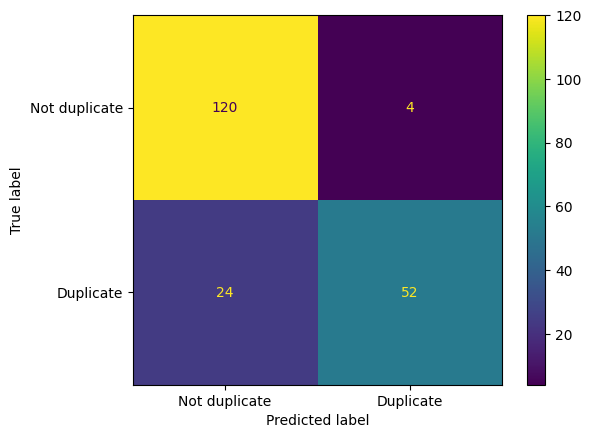

In [49]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not duplicate', 'Duplicate'])
disp.plot()
plt.show()